#  &#x1F4D1; **作业 9: AI的可解释性**
作业说明： https://docs.google.com/presentation/d/1KSvfraupHDBnBriVqWCRpB0554rV66SOcaqdtFtqIkk/edit?usp=sharing

本作业不提供`python script`版本

若有任何问题，欢迎来信至助教邮箱： mlta-2022-spring@googlegroups.com

## 最后期限
普通话/英语: 4/29开始, 5/20到期

# &#x1F4D6; **作业 9: Part 1 CNN 可解释性**

## 数据下载

In [1]:
!pip install gdown

In [2]:
# 下载数据
!gdown --id '1QntUQuWJoVR8h5FoeDa56xrQSdcCwFeD' --output food.zip
!unzip food.zip

# 下载预训练好的模型
!gdown --id '1-Qw-oIJ0cSo2iG_n_U9mcJqXc2-LCSdV' --output checkpoint.pth

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QntUQuWJoVR8h5FoeDa56xrQSdcCwFeD
To: /kaggle/working/food.zip
100%|█████████████████████████████████████████| 621k/621k [00:00<00:00, 106MB/s]
Archive:  food.zip
   creating: food/
  inflating: food/0_0.jpg            
  inflating: food/1_1.jpg            
  inflating: food/1_2.jpg            
  inflating: food/2_3.jpg            
  inflating: food/2_4.jpg            
  inflating: food/3_5.jpg            
  inflating: food/5_6.jpg            
  inflating: food/6_7.jpg            
  inflating: food/8_8.jpg            
  inflating: food/9_9.jpg            
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need t

## 加载包（环境设置）

In [ ]:
!pip install lime

In [5]:
import os
import sys
import argparse
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable
from argparse import Namespace
from tqdm.auto import tqdm

## 参数配置

In [6]:
args = Namespace(
    ckptpath='./checkpoint.pth',
    dataset_dir='./food/',
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    seed=2023
)

# 设置全局的随机种子
def all_seed(seed = 6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed) 
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed) 
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed) 
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')


all_seed(args.seed)

Set env random_seed = 2023


## 模型

In [7]:
# Model definition
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        def building_block(indim, outdim):
            return [
            nn.Conv2d(indim, outdim, 3, 1, 1),
            nn.BatchNorm2d(outdim),
            nn.ReLU(),
            ]
        def stack_blocks(indim, outdim, block_num):
            layer_list = building_block(indim, outdim)
            for i in range(block_num - 1):
                layer_list += building_block(outdim, outdim)
            layer_list.append(nn.MaxPool2d(2, 2, 0))
            return layer_list

        cnn_list = []
        cnn_list += stack_blocks(3, 128, 3)
        cnn_list += stack_blocks(128, 128, 3)
        cnn_list += stack_blocks(128, 256, 3)
        cnn_list += stack_blocks(256, 512, 1)
        cnn_list += stack_blocks(512, 512, 1)
        self.cnn = nn.Sequential( * cnn_list)

        dnn_list = [
          nn.Linear(512 * 4 * 4, 1024),
          nn.ReLU(),
          nn.Dropout(p = 0.3),
          nn.Linear(1024, 11),
        ]
        self.fc = nn.Sequential( * dnn_list)

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fc(out)

In [8]:
model = Classifier().to(args.device)
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## 定义与创建Dataset

In [9]:
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        self.paths = paths
        self.labels = labels
        tr_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor()
        ])
        evl_transform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor()
        ])
        self.transform = tr_transform if mode == 'train' else evl_transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y
    
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)
    
    
def get_paths_labels(path):
    def my_key(name):
        return int(name.replace(".jpg","").split("_")[1])+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels


train_paths, train_labels = get_paths_labels(args.dataset_dir)
train_set = FoodDataset(train_paths, train_labels, mode='eval')

### 样本查看

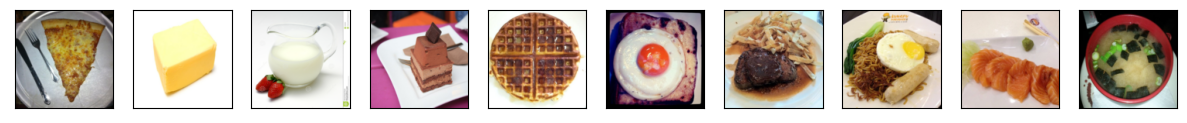

In [10]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs]
for i, img in enumerate(images):
    axs[i].imshow(img.cpu().permute(1, 2, 0))

## &#x2728; Lime (Q1~4) 
[Lime](https://github.com/marcotcr/lime) 是一个关于解释机器学习分类器(`classifier`)正在做什么的包。我们可以先用它来观察模型。  
也可以通过阅读[Local Interpretable Model-Agnostic Explanations (LIME): An Introduction](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)来了解lime的大致原理

这里我们通过：
- `lime_image.LimeImageExplainer().explain_instance` 对我们的CNN模型进行解释  
- `explaination.get_image_and_mask` 将关注用于分类的特征可视化

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


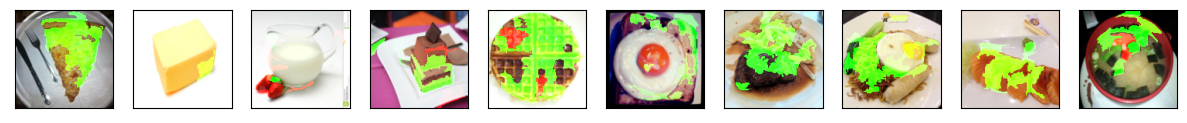

In [11]:
def predict(ipt):
    # ipt: numpy array, (batches, height, width, channels)
    model.eval()
    input = torch.FloatTensor(ipt).permute(0, 3, 1, 2)
    # pytorch tensor, (batches, channels, height, width)
    output = model(input.cuda())
    return output.detach().cpu().numpy()

def segmentation(input):
    # 借助skimage.segmentation中的分割图像方法slic，将图像分割成200块
    return slic(input, n_segments=200, compactness=1, sigma=1, start_label=1)


fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs]
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    x = image.astype(np.double)
    # numpy array for lime
    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance
    lime_img, mask = explaination.get_image_and_mask(
                                label=label.item(),
                                positive_only=False,
                                hide_rest=False,
                                num_features=11, #  进行解释的最大特征数-图片mask颜色不一样
                                min_weight=0.05
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

## &#x2728; 显著性Map`Saliency Map` (Q5~9)

热图突出显示输入图像中在分类任务中贡献最大的像素。
参考: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

我们在模型中放入一张图像，然后计算损失。因此，损失与下列三个因素相关：
*   图像：image
*   模型（参数）：model parameters
*   标签：label

一般来说，我们改变模型参数以适应“图像”和“标签”。当向后传播时，我们计算**损失对模型参数**的偏微分值，然后进行梯度下降。

现在，我们再看一眼。当我们改变图像的像素值时，**损失对图像**的偏微分值显示了损失的变化。我们可以说这意味着像素的重要性。我们可以将其可视化，以证明图像的哪一部分对模型的判断贡献最大。

In [12]:
def normalize(image):
    # maxMinScale
    return (image - image.min()) / (image.max() - image.min())
    # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # 允许x进行微分计算
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    # saliencies = x.grad.abs().detach().cpu()
    # 拿取梯度最大值 (batch, channels, height, width) -> (batch, height, width) 
    saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

    # 对每个图片单独进行归一化： 因为它们的梯度可能在比例上有所不同
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

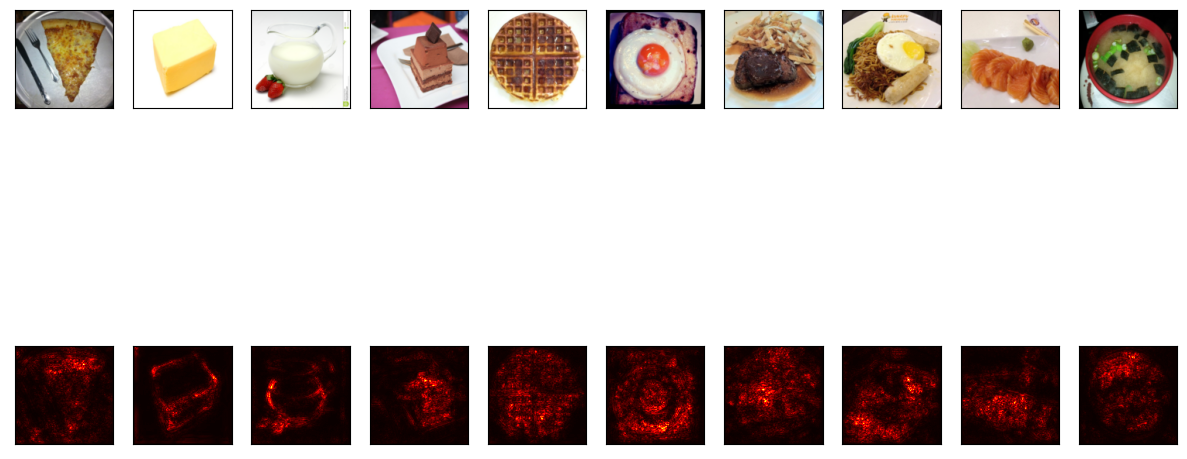

In [15]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        if row==0: # 原来的图片 - image
            axs[row][column].imshow(img.permute(1, 2, 0).numpy())
          # permute是什么：
          # 在pytorch中, 图像存储维度为 (channels, height, width)
          # 在matplotlib中, 图像存储维度为 (height, width, channels)
          # permute用以改变图像的 dim
          # 比如：img.permute(1, 2, 0) 表示,
          # - 原来的第1维度->变成第0维度  
          # - 原来的第2维度->变成第1维度 
          # - 原来的第0维度->变成第2维度 
        else: # channel中梯度最大的灰度图片- saliencies
            axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
    
plt.show()
plt.close()

## &#x2728; Smooth Grad (Q10~13)
Smooth grad 的方法是，在图片中随机的加入`noise`, 然后得到不同的`heetmap`，把这些`heetmap`进行平均，这样能得到一个比较抗`noisy gradient`。


参考文献: https://arxiv.org/pdf/1706.03825.pdf

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

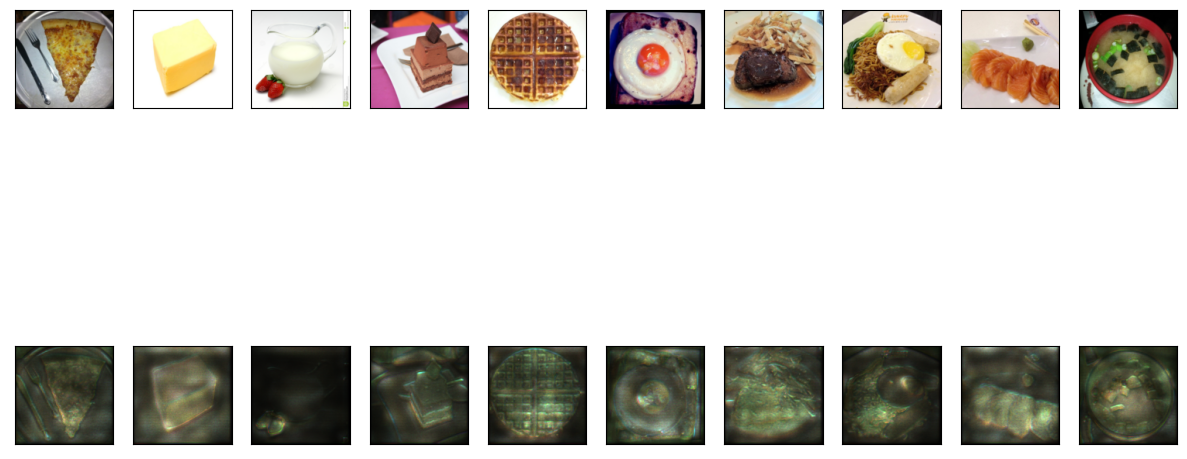

In [16]:
def normalize(image):
    # maxMinScale
    return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
    model.eval()
    #x = x.cuda().unsqueeze(0)

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
    smooth = np.zeros(x.cuda().unsqueeze(0).size())
    for i in tqdm(range(epoch), leave=False):
        # 增加噪声
        noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
        x_mod = (x+noise).unsqueeze(0).cuda()
        x_mod.requires_grad_()

        y_pred = model(x_mod)
        loss_func = torch.nn.CrossEntropyLoss()
        loss = loss_func(y_pred, y.cuda().unsqueeze(0))
        loss.backward()

        # 和 saliency map 差不多求梯度绝对值， 但是不进行最大值
        smooth += x_mod.grad.abs().detach().cpu().data.numpy()
    smooth = normalize(smooth / epoch) # 不要忘记进行归一化
    # smooth = smooth / epoch # try this line to answer the question
    # (batch, channels, height, width) -> (batch, channels, height, width) 
    return smooth

# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
    smooth.append(smooth_grad(i, l, model, 500, 0.4))
smooth = np.stack(smooth)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for row, target in enumerate([images, smooth]):
    for column, img in enumerate(target):
        axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)))

## &#x2728; Filter Explanation (Q14~17)

这里我们想知道每个`filter`到底认出了什么。我们会做两件事：
- Filter activation: 挑出几张图片，看看图片中哪些位置 activate 这个 filter
- Filter visualization: 找出怎样的 image 可以最大程度的 activate 这个 filter

实际上比较困难的地方是，通常我们是直接把 image 丢进 model, 进行正常的`forward`，比如：
```python
loss = model(image)
loss.backward()
```
我们要怎么得到中间某层 CNN 的 output ?
1. 可以直接修改`model definition`, 让 `forward` 同时也`return activation map`, 单这样的写法就麻烦了，会涉及大量的代码改动
2. 直接用 pytorch 提供了方便的方法: **hook**


In [17]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
    """
    x: 输入的图片
    cnnid: cnn layer id
    filterid: which filter
    """
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
    
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # 当模型`forwards` 通过 layer[cnnid], 它会调用hook方法
    # hook方法保存 layer[cnnid] 的输出
    # 前向传播结束后，我们会得到 loss 和 layer activation

    # Filter activation: x 通过 filter 生成 activation map
    model(x.cuda())

    # 根据函数参数给定的filterid，获取特定filterid的激活映射`activation map`
    # 我们只需要绘制它，这样我们就可以从图中分离出来，并保存为cpu张量
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
    
    # Filter visualization: 找到最能激活 filter的图像
    x = x.cuda()
    x.requires_grad_()
    # input image gradient
    optimizer = Adam([x], lr=lr)
    # 使用优化器修改输入图像以放大过滤器激活（filter activation）
    for _ in range(iteration):
        optimizer.zero_grad()
        model(x)
        
        objective = -layer_activations[:, filterid, :, :].sum()
        # 我们想要最大化`filter activation`的总和, 所以我们加一个负号
        
        objective.backward()
        # 计算`filter activation`对输入图像的偏微分值
        optimizer.step()
        # 修改输入图像以最大化`filter activation`
    filter_visualizations = x.detach().cpu().squeeze()

    # 不要忘记移除 hook
    hook_handle.remove()
    # hook将在模型注册后存在，所以你必须在使用后将其移除。如果你想使用它，只需注册一个新的hook
    return filter_activations, filter_visualizations

In [18]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

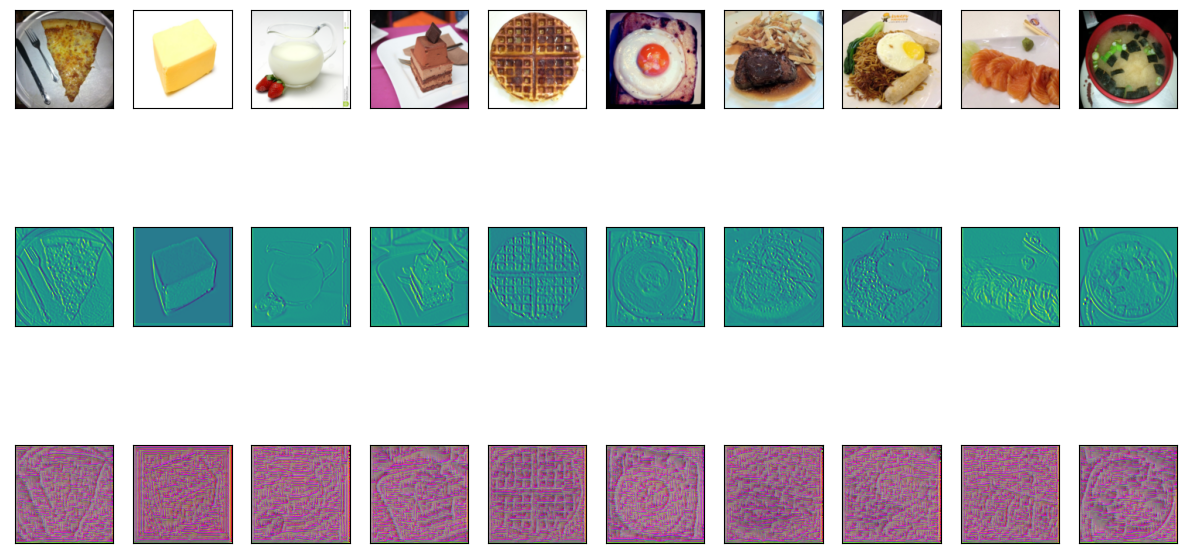

In [19]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=6, filterid=0, iteration=100, lr=0.1)

fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()

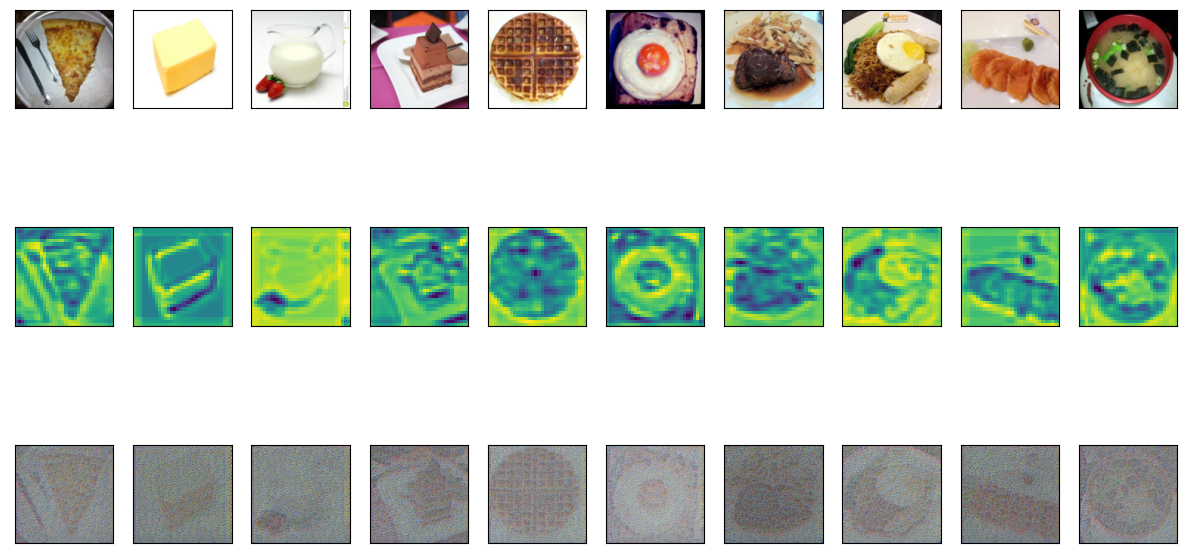

In [20]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=23, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


## &#x2728; 综合梯度(`Integrated Gradients`) (Q18~20)

In [23]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # 将模型设置成 evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # 生成缩放的xbar图像
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        input_image.requires_grad=True
        model_output = self.model(input_image)
        self.model.zero_grad()
        # 反向探测目标
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # 反向传播
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # 转成numpy (1,3,128,128) -> (3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # 生成缩放的xbar图像
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # 初始化由零组成的图像
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # 从xbar图像生成梯度
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # 从xbar图像中添加重新缩放的梯度
            integrated_grads = integrated_grads + single_integrated_grad/steps

        # (1,3,128,128) -> (3,128,128)
        return integrated_grads[0]


def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

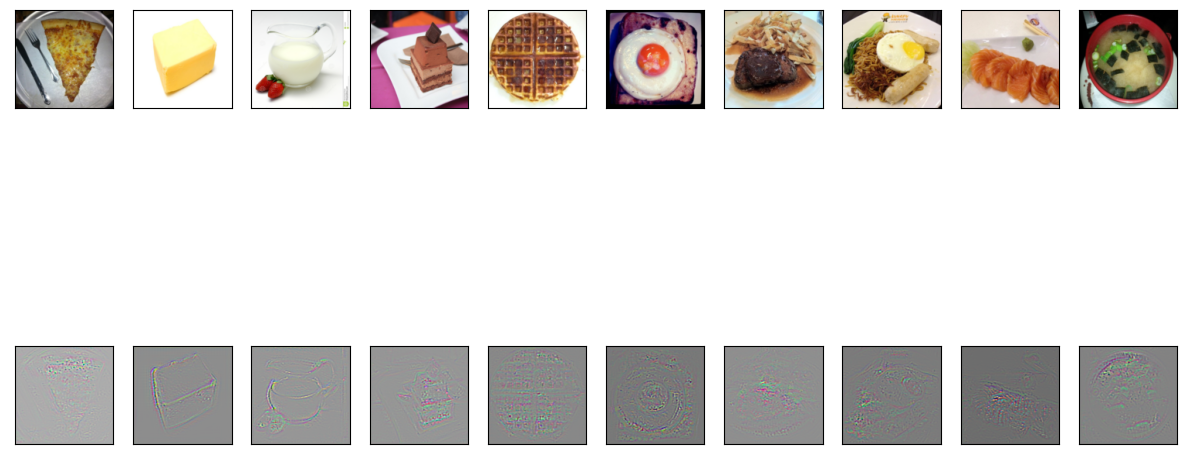

In [27]:
images, labels = train_set.getbatch(img_indices)
images = images.cuda()

IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
    img = img.unsqueeze(0)
    integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 10))

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
    axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()

#### 祝贺你完成 `HW09`的第一部分！！差不多完成了！！！

# &#x1F4D6; **作业 9: Part 2 BERT 可解释性**

In [29]:
from IPython import display
# 可以直接访问 https://exbert.net/exBERT.html
# display.IFrame("https://exbert.net/exBERT.html", width=1600, height=1600)

## 加载包 (For Questions 25 - 30)

In [30]:
!pip install transformers==4.5.0

import numpy as np
import random
import torch

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from transformers import BertModel, BertTokenizerFast

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
# 设置台湾字体便于在matplotlib中显示繁体字； 下載台北思源黑体  命名taipei_sans_tc_beta.ttf，移至指定路徑
!gdown --id '1JWHUSlcPwoEzmr0VE6J71jcnwinH10G6' --output taipei_sans_tc_beta.ttf
# 自定义字体变量
myfont = FontProperties(fname=r'taipei_sans_tc_beta.ttf')
# 后面使用的时候只要 fontproperties=myfont 就可以了
##### 代码参考： https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb #####

plt.rcParams['figure.figsize'] = [12, 10]
# seed 设置已经在前面设置了

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 54.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=71d50d220596e244c3dc4aa5049f01ba5ec3121b59171d84ef9c435ee53e24ba
  Stored in directory: /root/.cache/pip/wheels/5b/e0/77/05245143a5b31f65af6a21f7afd3219e9fa4896f918af45677
Successfully built sacremoses
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.4
    Uninstalling transformers-4.27.4:
      Successfully uninstalled transformers-4.27.4
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: F

## &#x2728; Embedding 可视化 (Q25~27)

#### 我们现在有一个预训练好的模型，并在阅读理解上微调过

阅读理解需要4个步骤：（这些步骤并**不**是按照顺序排列的 ）
- 将类似的文字分群(基于语境中词语的关系)
- 提取答案
- 将类似的文字分群 (根据文字的意思)
- 从文章中寻找与问题有关的信息


#### 你可以在只看见模型`hidden states embedding`的情況下，找出各个layer的功能嗎?

### 下载`Tokenizers` 和模型`Models' hidden states`

In [31]:
!gdown --id '1h3akaNdouiIGItOqEs6kUZE-hAF0QeDk' --output hw9_bert.zip
!unzip hw9_bert.zip

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1h3akaNdouiIGItOqEs6kUZE-hAF0QeDk
To: /kaggle/working/hw9_bert.zip
100%|███████████████████████████████████████| 9.54M/9.54M [00:00<00:00, 112MB/s]
Archive:  hw9_bert.zip
   creating: hw9_bert/
   creating: hw9_bert/output/
  inflating: hw9_bert/output/model_q1  
  inflating: hw9_bert/output/model_q2  
  inflating: hw9_bert/output/model_q3  
   creating: hw9_bert/Tokenizer/
  inflating: hw9_bert/Tokenizer/special_tokens_map.json  
  inflating: hw9_bert/Tokenizer/tokenizer_config.json  
  inflating: hw9_bert/Tokenizer/vocab.txt  


### 载入Tokenizers

In [32]:
Tokenizer = BertTokenizerFast.from_pretrained("hw9_bert/Tokenizer")

### What to Visualize?

In [33]:
contexts, questions, answers = [], [], []

# Question 1
contexts += ["Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, \
            mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current \
            (AC) electricity supply system."]
questions += ["In what year was Nikola Tesla born?"]
answers += ["1856"]

# Question 2
contexts += ['Currently detention is one of the most common punishments in schools in the United States, the UK, Ireland, Singapore and other countries. \
            It requires the pupil to remain in school at a given time in the school day (such as lunch, recess or after school); or even to attend \
            school on a non-school day, e.g. "Saturday detention" held at some schools. During detention, students normally have to sit in a classroom \
            and do work, write lines or a punishment essay, or sit quietly.']
questions += ['What is a common punishment in the UK and Ireland?']
answers += ['detention']

# Question 3
contexts += ['Wolves are afraid of cats. Sheep are afraid of wolves. Mice are afraid of sheep. Gertrude is a mouse. Jessica is a mouse. \
            Emily is a wolf. Cats are afraid of sheep. Winona is a wolf.']
questions += ['What is Emily afraid of?']
answers += ['cats']

### <font color=darkred><b>TODO</font></b>
这是唯一需要修改才能回答的部分 Q25~27.m

In [34]:
# Choose from 1, 2, 3
QUESTION = 1

### 进行可视化

In [35]:
# 将问题和段落标记化`Tokenize`并编码为模型的输入格式
inputs = Tokenizer(questions[QUESTION-1], contexts[QUESTION-1], return_tensors='pt') 

# 在`encoded`的序列中获取[question, context] 的 [start, end] 位置
question_start, question_end = 1, inputs['input_ids'][0].tolist().index(102) - 1
context_start, context_end = question_end + 2, len(inputs['input_ids'][0]) - 2

# 长度为13的 tuple, 第一个元素时embedding的输出，1-12个元素分别为attention层的输出
outputs_hidden_states = torch.load(f"hw9_bert/output/model_q{QUESTION}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


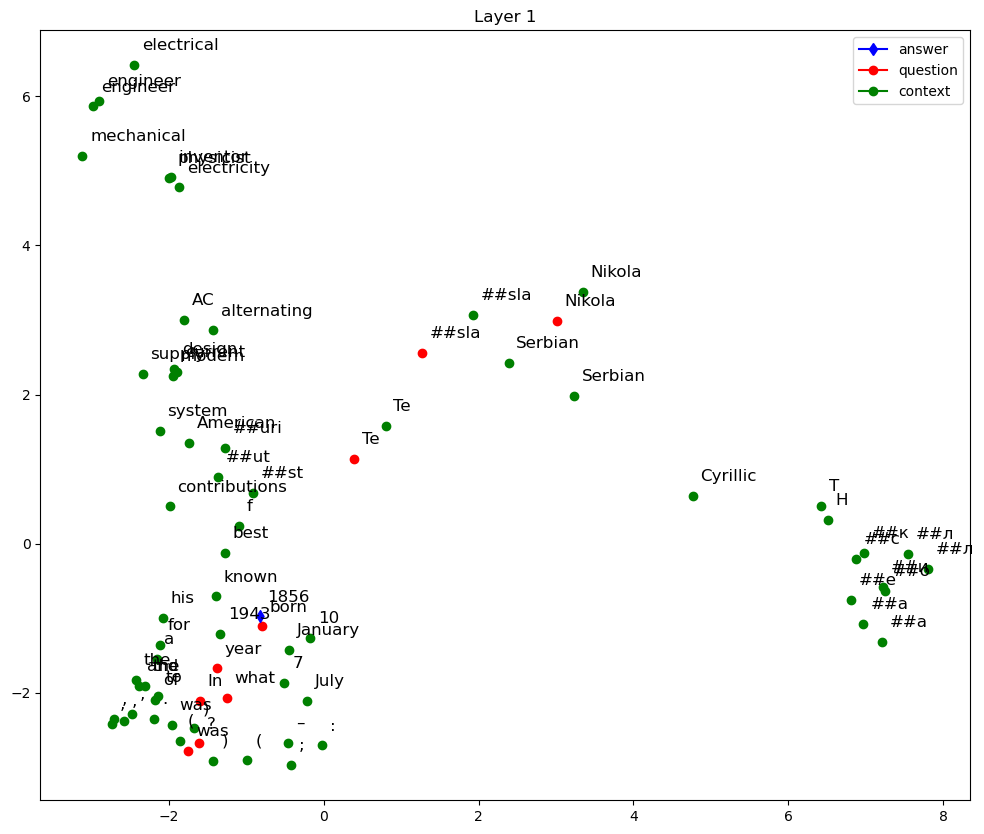

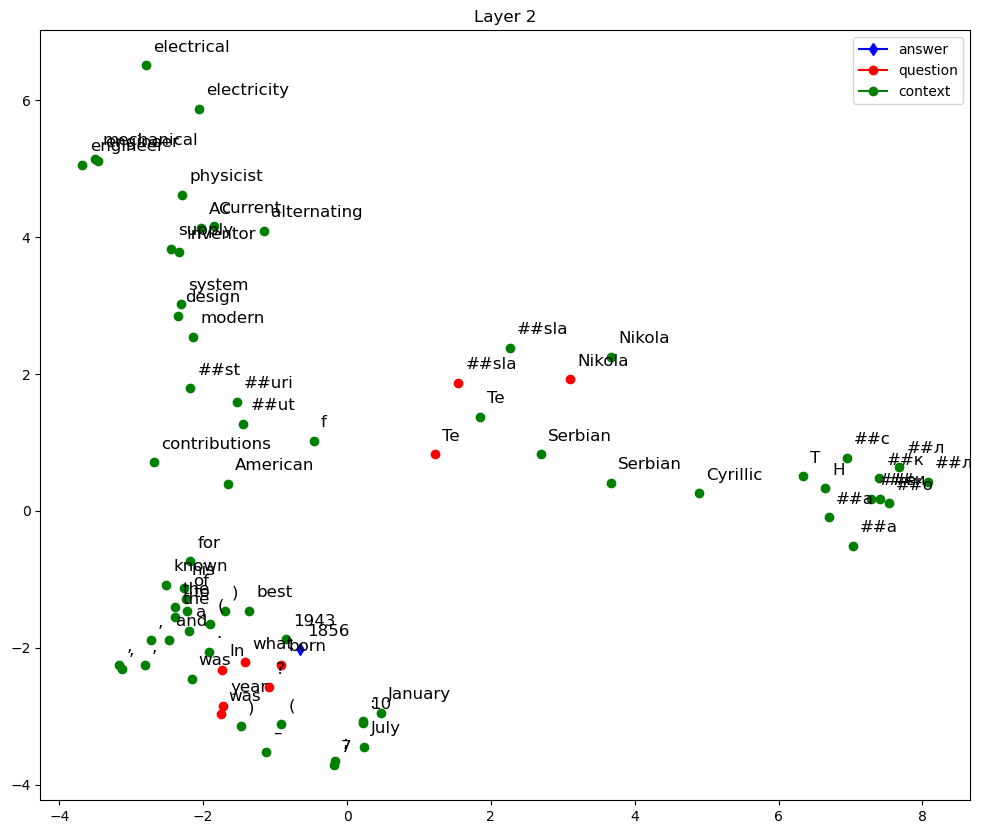

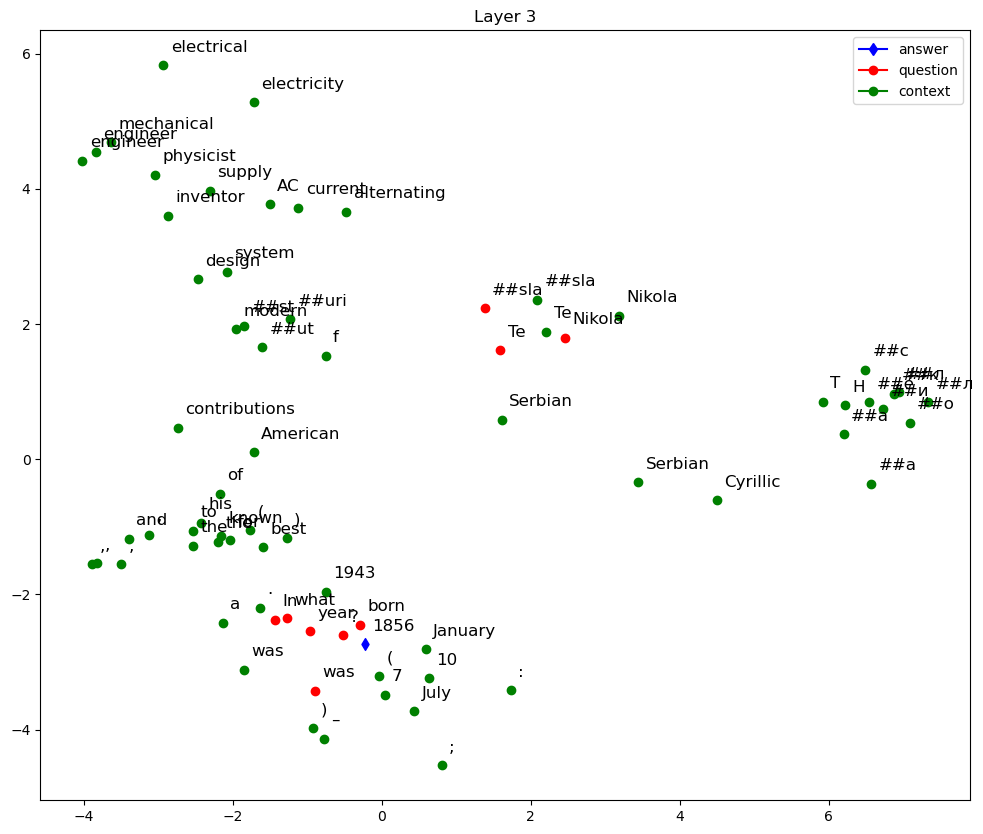

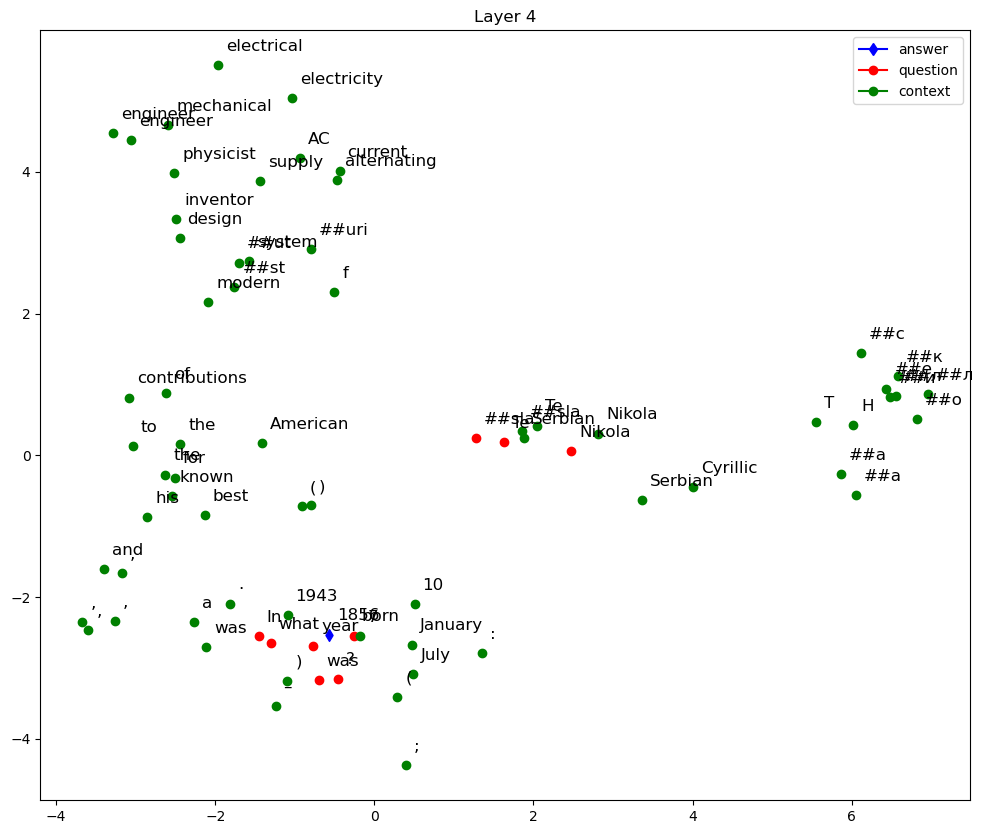

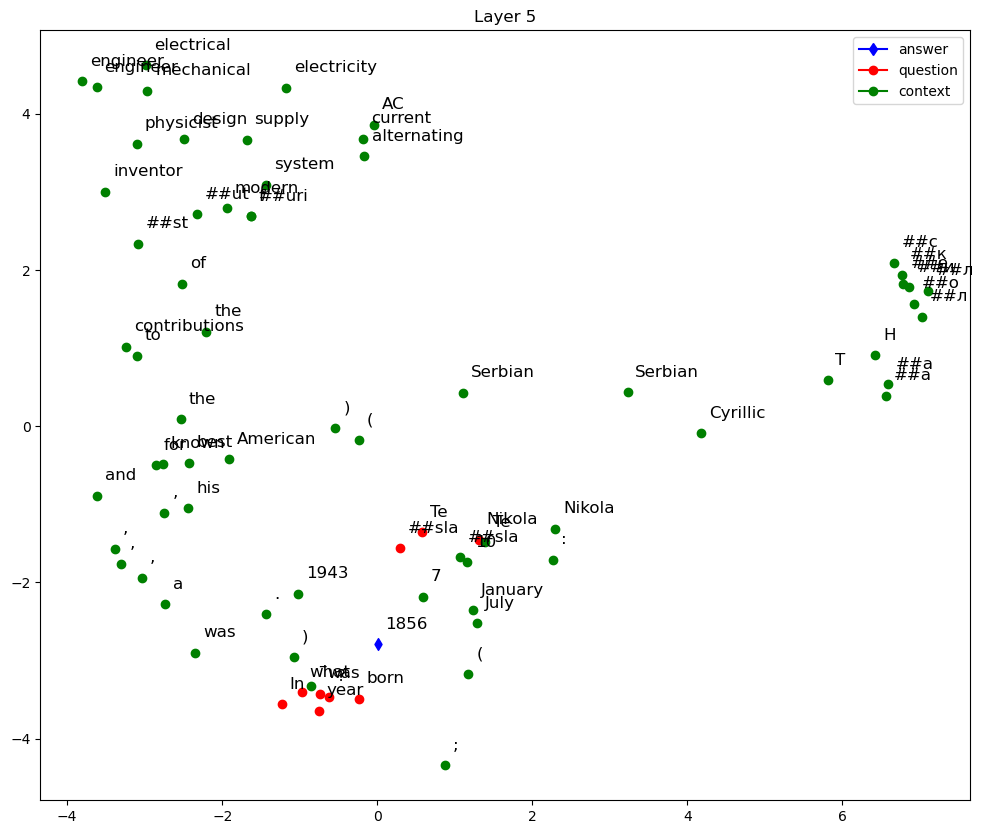

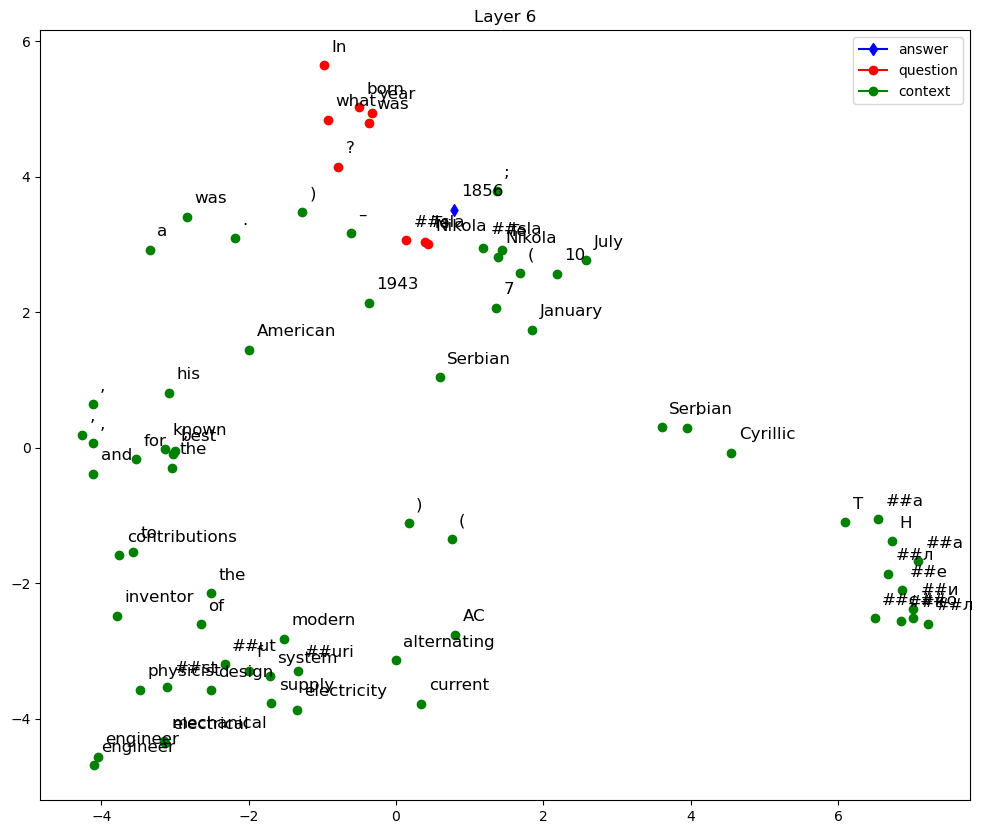

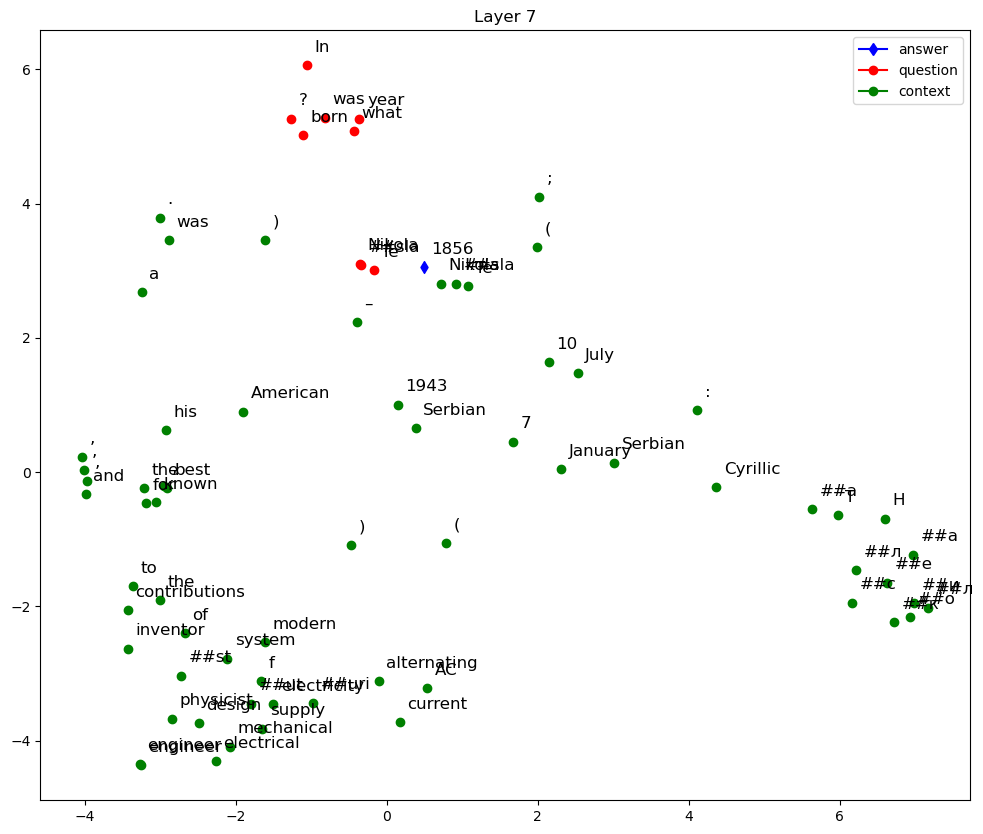

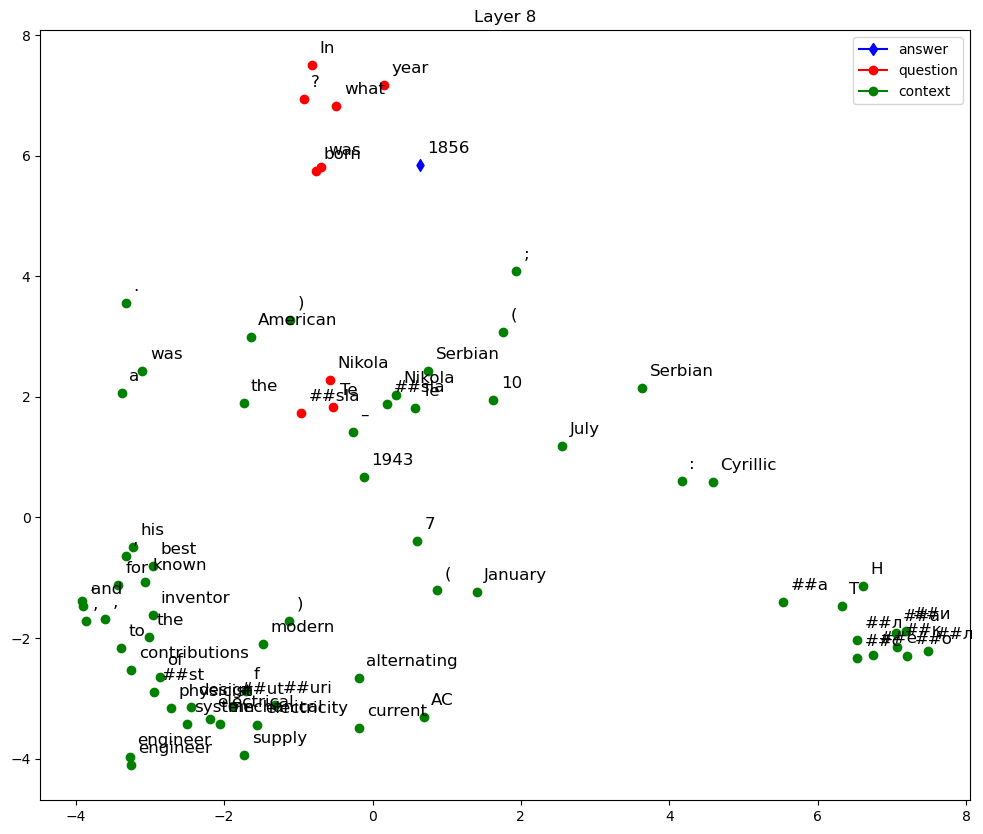

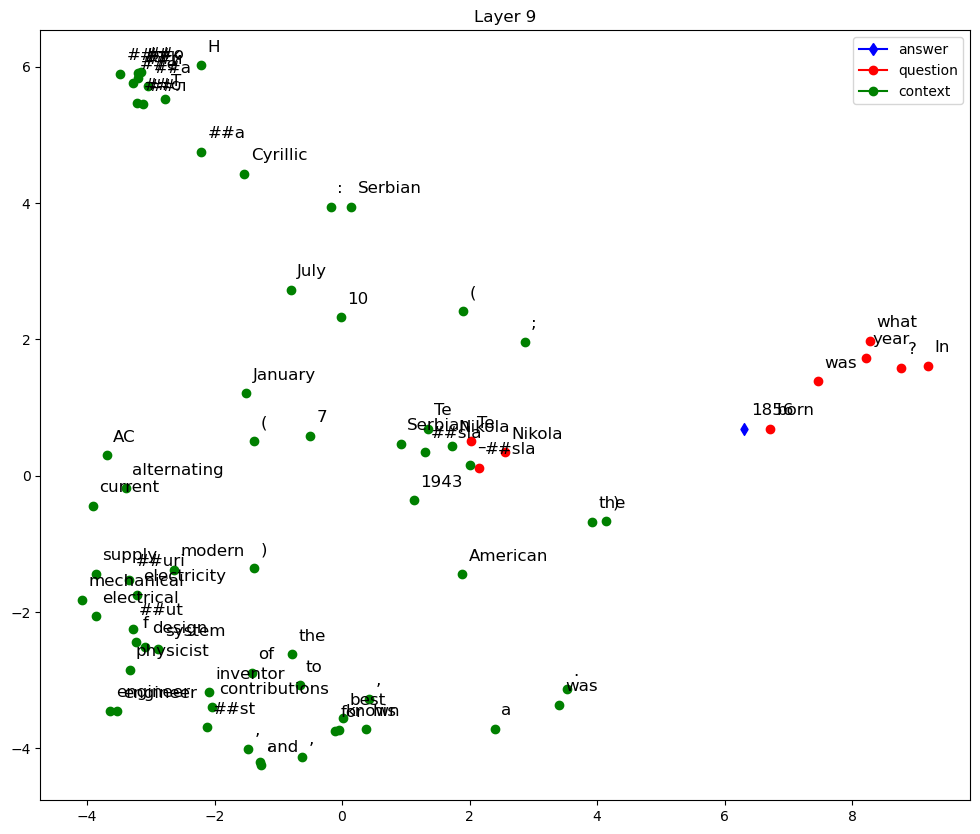

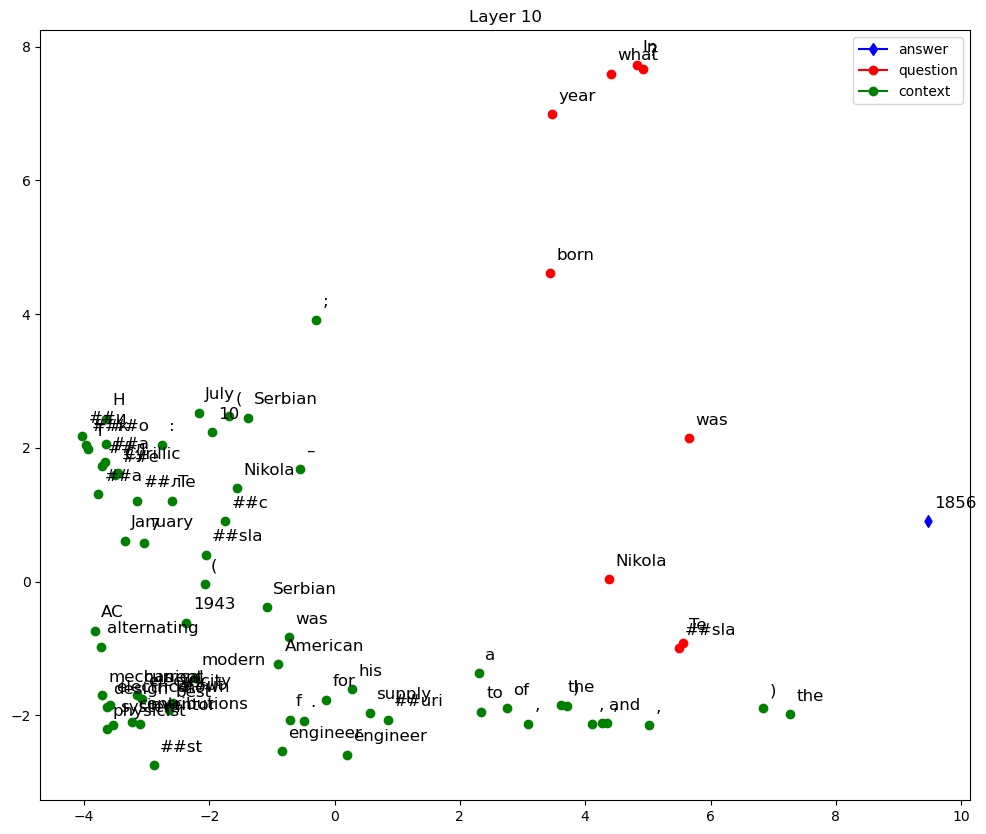

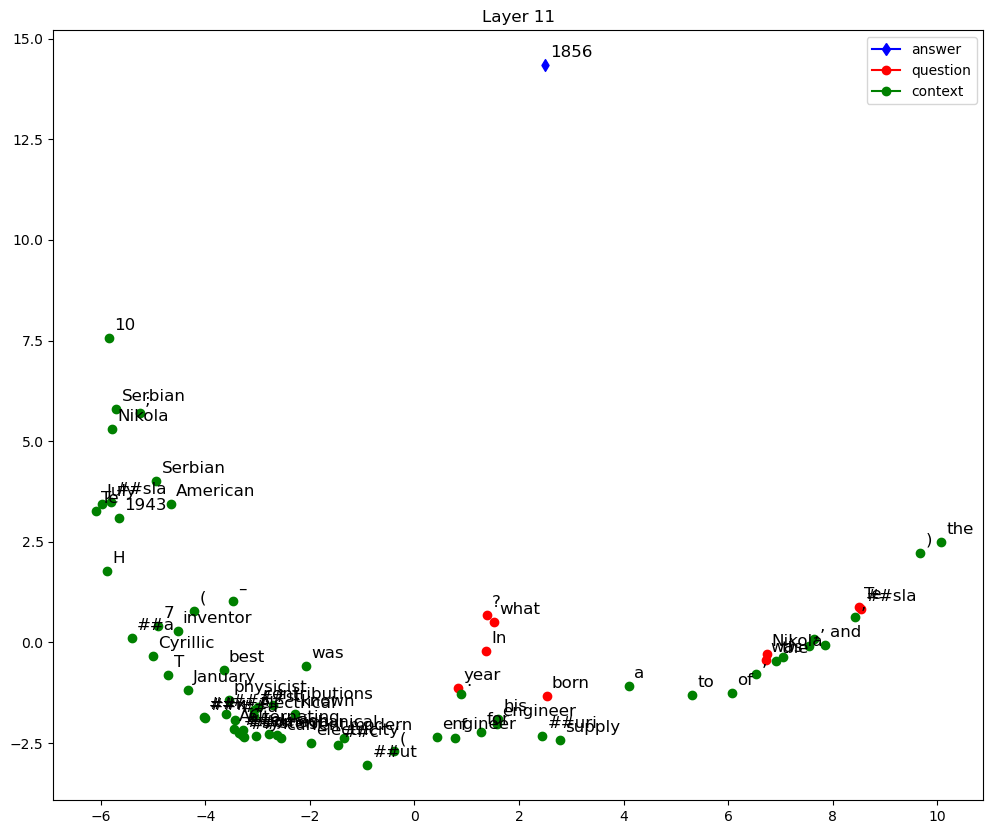

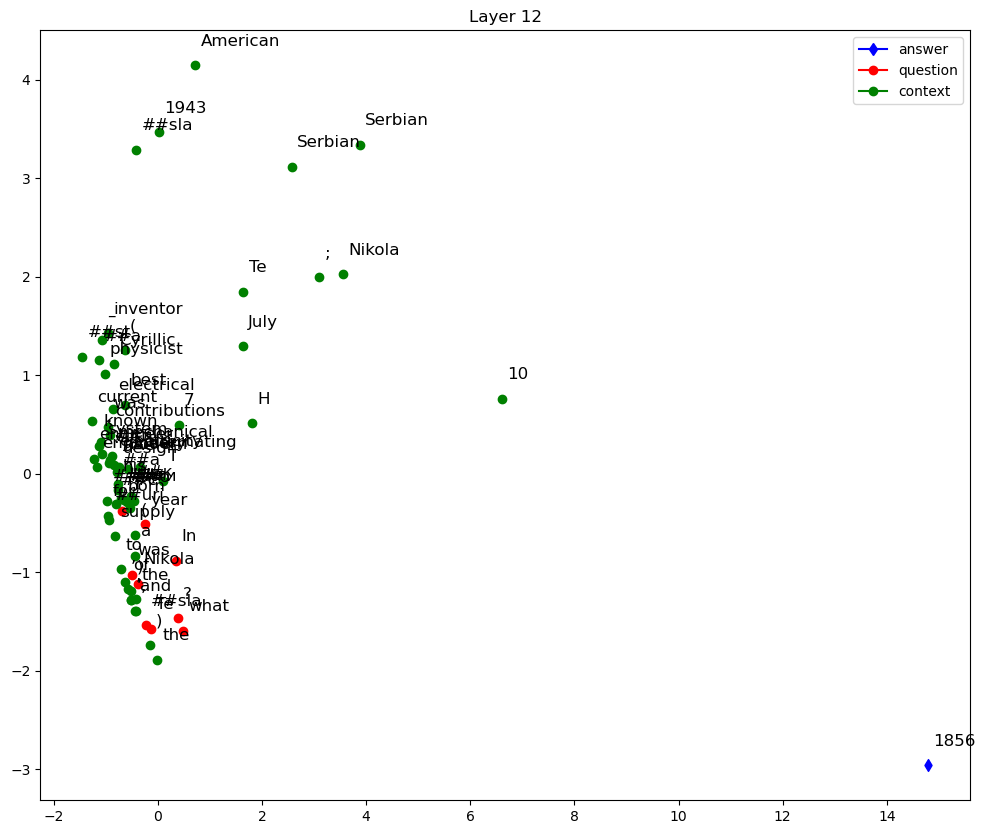

In [36]:
##### 遍历所有层的隐藏状态  #####
for layer_index, embeddings in enumerate(outputs_hidden_states[1:]): # 1st element is skipped
    # "embeddings" -> [1, sequence_length, 768], 768 是 BERT's 隐含层的dim
    # PCA (Principal Component Analysis) 将 "embeddings" 从 768 降维到 2  
    reduced_embeddings = PCA(n_components=2, random_state=0).fit_transform(embeddings[0])

    ##### 将降维后每个token的embedding绘制出来 ##### 
    for i, token_id in enumerate(inputs['input_ids'][0]):
        x, y = reduced_embeddings[i]
        word = Tokenizer.decode(token_id) # 用于标记点 （Decode token back to word）
        # 将 answer, question and context 用不同的颜色标识
        if word in answers[QUESTION-1].split(): # Check if word in answer
            plt.scatter(x, y, color='blue', marker='d') 
        elif question_start <= i <= question_end:
            plt.scatter(x, y, color='red')
        elif context_start <= i <= context_end:
            plt.scatter(x, y, color='green')
        else: # 跳过特殊 tokens [CLS], [SEP]
            continue
        plt.text(x + 0.1, y + 0.2, word, fontsize=12)

    # 绘制空点 便于用legend 标识不同点的代表含义
    plt.plot([], label='answer', color='blue', marker='d')  
    plt.plot([], label='question', color='red', marker='o')
    plt.plot([], label='context', color='green', marker='o')
    plt.legend(loc='best') 
    plt.title('Layer ' + str(layer_index + 1))
    plt.show()

## &#x2728; Embedding 分析(Q28~30)

In [37]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True).eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

### What to Visualize?

In [38]:
# 进行可视化的句子
sentences = []
sentences += ["今天買了蘋果來吃"]
sentences += ["進口蘋果（富士)平均每公斤下跌12.3%"]
sentences += ["蘋果茶真難喝"]
sentences += ["老饕都知道智利的蘋果季節即將到來"]
sentences += ["進口蘋果因防止水分流失故添加人工果糖"]
sentences += ["蘋果即將於下月發振新款iPhone"]
sentences += ["蘋果獲新Face ID專利"]
sentences += ["今天買了蘋果手機"]
sentences += ["蘋果的股價又跌了"]
sentences += ["蘋果押寶指紋辨識技術"]

### <font color=darkred><b>TODO</font></b>

这是唯一需要修改才能回答的部分  Q28~30.

In [39]:
# 选择每个句子中的 蘋 字
select_word_index = [4, 2, 0, 8, 2, 0, 0, 4, 0, 0]
# select_word_index = [5, 3, 1, 9, 3, 1, 1, 5, 1, 1]

In [41]:
def euclidean_distance(a, b):
    # 欧式距离
    return np.linalg.norm(a-b,ord=2)

def cosine_similarity(a, b):
    # 余弦相似
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 选择评估句子建距离的指标：欧氏距离-euclidean_distance, 余弦距离-cosine_similarity
METRIC = cosine_similarity

def get_select_embedding(output, tokenized_sentence, select_word_index):
    # 选择进行可视化的层, 0 ~12
    LAYER = 12
    # 获取 layer's hidden state
    hidden_state = output.hidden_states[LAYER][0]
    # 将 select_word_index 通过tokenized 转换后才能 select_token_index 
    select_token_index = tokenized_sentence.word_to_tokens(select_word_index).start
    # 返回选择词的embedding
    return hidden_state[select_token_index].numpy()

### 进行可视化

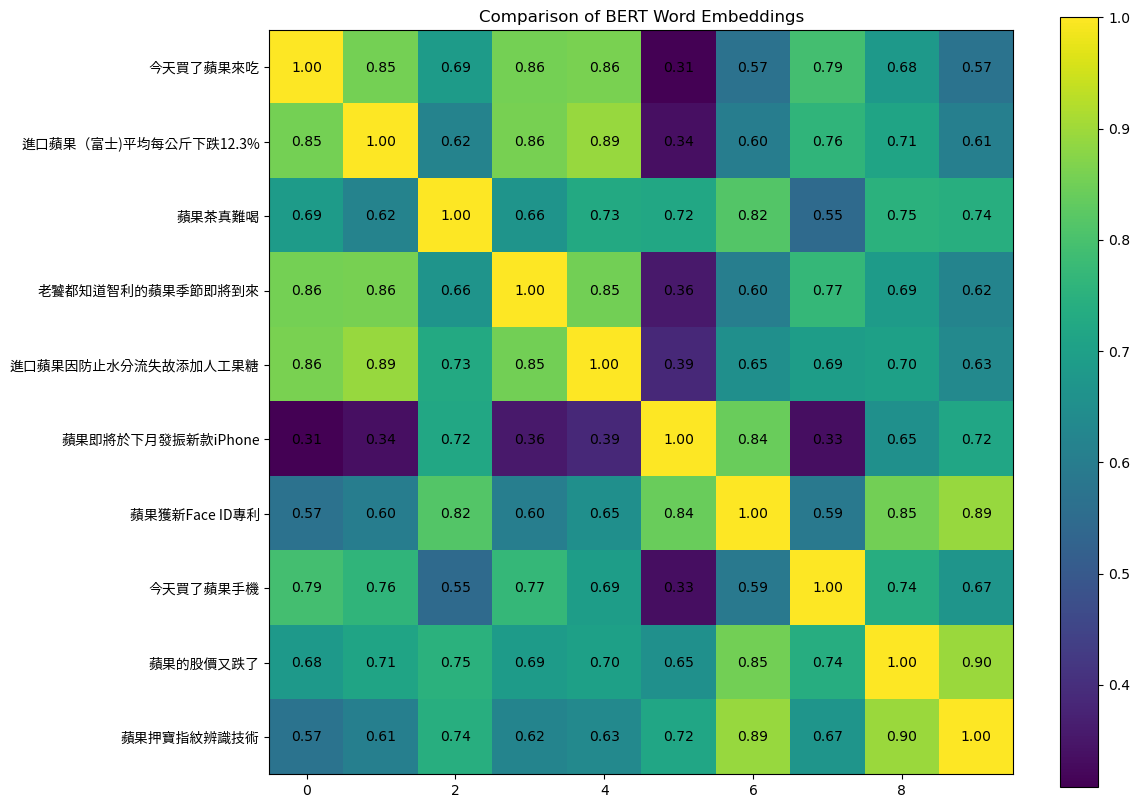

In [42]:
# 将句子标记化（Tokenize）并编码为模型的输入格式
tokenized_sentences = [tokenizer(sentence, return_tensors='pt') for sentence in sentences]

# 获取输出
with torch.no_grad():
    outputs = [model(**tokenized_sentence) for tokenized_sentence in tokenized_sentences]

# 获取选择句子中对应词的embedding. "embeddings" 维度(len(sentences), 768) 768 是 BERT的 hidden state 维度
embeddings = [get_select_embedding(outputs[i], tokenized_sentences[i], select_word_index[i]) for i in range(len(outputs))]

# 对输入进行两量比较 "similarity_matrix" 维度为 [len(sentences), len(sentences)]
similarity_matrix = pairwise_distances(embeddings, metric=METRIC) 

##### 绘制相似矩阵 #####
plt.rcParams['figure.figsize'] = [12, 10] # 设置图像大小
plt.imshow(similarity_matrix) # 绘制相似热力
plt.colorbar()
plt.yticks(ticks=range(len(sentences)), labels=sentences, fontproperties=myfont)  # 使用台湾字体
plt.title('Comparison of BERT Word Embeddings') 
for (i,j), label in np.ndenumerate(similarity_matrix): # np.ndenumerate 是二维版本的 enumerate
    plt.text(i, j, '{:.2f}'.format(label), ha='center', va='center') 
plt.show()  